In [1]:
import sklearn.datasets
import urllib.request

from loss import LogisticRegression

from cubic import Cubic, Cubic_LS
from optmethods.first_order import Gd
from optmethods.second_order import RegNewton

import matplotlib.pyplot as plt
import numpy as np

In [16]:
dataset = 'mushrooms'
if dataset == 'mushrooms':
    data_url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/mushrooms"
    data_path = './mushrooms'
else:
    data_url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/w8a"
    data_path = './w8a'
f = urllib.request.urlretrieve(data_url, data_path)
A, b = sklearn.datasets.load_svmlight_file(data_path)
A = A.toarray()

In [17]:
print(A.shape)

(8124, 112)


In [18]:
loss = LogisticRegression(A, b, l1=0, l2=0)
n, dim = A.shape
L = loss.smoothness
l2 = 1e-10 * L # make the problem ill-conditioned
loss.l2 = l2
x0 = np.ones(dim) * 0.5
it_max = 200
memeory_size = 10

In [19]:
gd = Gd(loss=loss, label='GD')

cub_ls_krylov = Cubic_LS(loss=loss, label='Cubic Newton with LS (Krylov subspace m={})'.format(memeory_size),
                         cubic_solver="krylov", solver_it_max=memeory_size)
cub_ls_root = Cubic_LS(loss=loss, label='Cubic Newton with LS',cubic_solver="root")


adan = RegNewton(loss=loss, adaptive=True, use_line_search=True, 
                    label='AdaN')

In [16]:
# cub_10 = Cubic(loss=loss, label='Cubic Newton',cubic_solver="krylov", solver_it_max=10)
# print(f'Running optimizer: {cub_10.label}')
# cub_10.run(x0=x0, it_max=it_max)
# cub_10.compute_loss_of_iterates()

Running optimizer: Cubic Newton


100%|██████████| 2000/2000 [06:48<00:00,  4.90it/s]


In [6]:
# cub.residuals

[]

In [20]:
print(f'Running optimizer: {gd.label}')
gd.run(x0=x0, it_max=it_max)
gd.compute_loss_of_iterates()

Running optimizer: GD


100%|██████████| 200/200 [00:00<00:00, 549.53it/s]


In [21]:
print(f'Running optimizer: {adan.label}')
adan.run(x0=x0, it_max=50)
adan.compute_loss_of_iterates()

Running optimizer: AdaN


100%|██████████| 50/50 [00:00<00:00, 87.10it/s]


In [22]:
print(f'Running optimizer: {cub_ls_root.label}')
cub_ls_root.run(x0=x0, it_max=it_max)
cub_ls_root.compute_loss_of_iterates()

Running optimizer: Cubic Newton with LS


 20%|█▉        | 39/200 [00:00<00:02, 65.31it/s]/Users/ruichenj/Library/CloudStorage/WorkDocsDrive-Documents/stochastic_LS/cubic.py:248: RuntimeWarning: overflow encountered in scalar power
  return lam**2 - M**2 * np.linalg.norm(s_lam)**2
/Users/ruichenj/Library/CloudStorage/WorkDocsDrive-Documents/stochastic_LS/cubic.py:254: RuntimeWarning: overflow encountered in scalar power
  return 2*lam - M**2 * phi_lam_grad
/Users/ruichenj/anaconda3/envs/p38/lib/python3.8/site-packages/scipy/optimize/_zeros_py.py:306: RuntimeWarning: invalid value encountered in scalar divide
  newton_step = fval / fder
100%|██████████| 200/200 [00:16<00:00, 12.50it/s]


In [24]:
print(f'Running optimizer: {cub_ls_krylov.label}')
cub_ls_krylov.run(x0=x0, it_max=it_max)
cub_ls_krylov.compute_loss_of_iterates()

Running optimizer: Cubic Newton with LS (Krylov subspace m=10)


  0%|          | 0/200 [00:00<?, ?it/s]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 10 is different from 1)

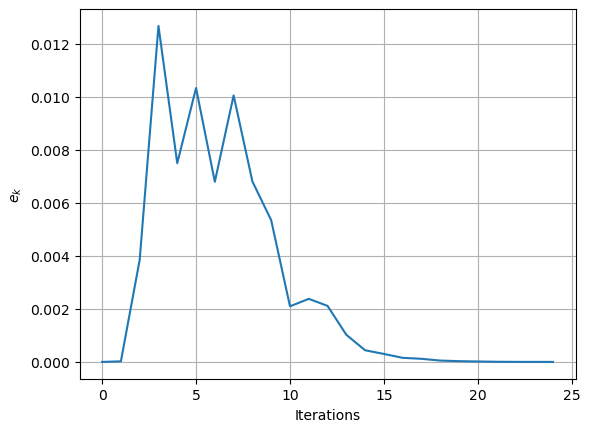

In [25]:
plt.plot(cub_ls_krylov.residuals)
plt.xlabel('Iterations')
plt.ylabel(r'$e_k$')
plt.grid(which='both')

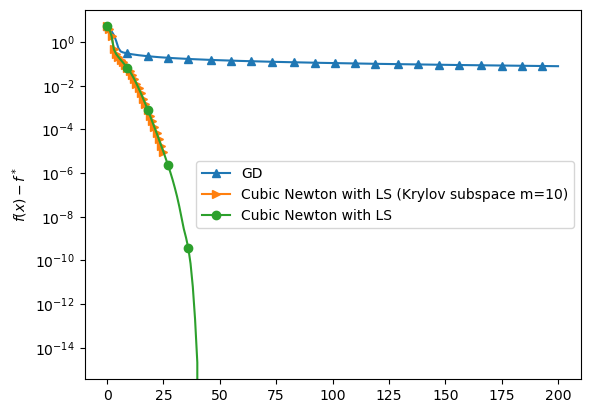

In [27]:
gd.trace.plot_losses(marker='^')
cub_ls_krylov.trace.plot_losses(marker='>')
cub_ls_root.trace.plot_losses(marker='o')
# cub_root.trace.plot_losses(marker='*', label='cubic Newton (exact)')
# plt.xscale('log')
# print(cub.trace.loss_vals)
plt.yscale('log')
plt.legend()
plt.show()

In [13]:
print(L)

0.6611993844944692


In [21]:
from cubic import Cubic
cub_10 = Cubic(loss=loss, label='Cubic Newton',cubic_solver="krylov", solver_it_max=10)

In [22]:
cub_10.run(x0=x0, it_max=10)

100%|██████████| 10/10 [00:02<00:00,  4.11it/s]
